A notebook demostrating the use of Archie's Law to estimate water qulity estimates. The equation is the following.

logCw = logCt – mlogØ

 

where Cw is the predicted fluid EC (S/m), Ct is bulk conductivity and logØ is the free water.

We are trying to estimate fluid EC at on a grid given AEM conductivity (interpolated) and mobile water (interpolated) and a cementation factor based on empirical relationships developed using pore fluid EC and borehole NMR.

Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [6]:
import pandas
import rasterio
import numpy as np
from hydrogeol_utils import SNMR_utils, AEM_utils, spatial_functions, borehole_utils
import netCDF4
import math
import os, glob
import gc
from geophys_utils._netcdf_line_utils import NetCDFLineUtils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
import rasterio
from rasterio import Affine
from rasterio.warp import reproject, Resampling
from scipy import interpolate, stats
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
def resample_raster2array(infile, newaff, new_shape, driver='GTiff',
                    null = -999):

    # Open
    src = rasterio.open(infile)

    # Extract data as an array
    arr = src.read()[0]

    # Get the affine
    aff = src.transform


    # Create new array with the grid
    # coordinates from the kriging
    newarr = np.empty(shape=new_shape)

    # Reproject
    reproject(
        arr, newarr,
        src_transform=aff,
        dst_transform=newaff,
        src_crs=src.crs,
        dst_crs=src.crs,
        resampling=Resampling.bilinear)

    src.close()

    # This is a hack to handle different nulls which are always lower than -900
    
    newarr[newarr < -900] = np.nan

    return newarr

def slice_conductivity(logcondprofile, cond_intervals, base, top):
    old_intervals = cond_intervals.copy()
    
    old_intervals[:,0]= old_intervals[:,0] + 0.01

    old_intervals = np.sort(old_intervals.flatten())
    
    # repeat params
    params = np.repeat(logcondprofile, 2)
    
    # Interpolate

    f = interpolate.interp1d(old_intervals,
                             params, kind='linear')
    
    new_intervals = np.array([top,base])
    
    xnew = new_intervals
    
    xnew = xnew[(xnew > np.min(old_intervals)) & (xnew < np.max(old_intervals))]

    xnew = np.sort(np.concatenate((old_intervals, xnew)))

    ynew = f(xnew)
    mask = np.logical_and(xnew <= base, xnew >= top)
    
    new_profile = ynew[mask]
    new_depths = xnew[mask]
    
    # Calculate thickness
    thickness = spatial_functions.depth_to_thickness(new_depths)[:-1]
    # Calculate weights based on thickness
    weights = thickness/(thickness.sum())
    
    # Now multiply these weights by the profile
    weighted_logcond = weights * new_profile[:-1]
    
    return(np.sum(weighted_logcond))
    


In [7]:
# We will need to interpolate the SNMR for the top 5 metres of the saturated zone.
# OPen the labelled data from the transmissivity mapping

infile= r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\aquifer_properties\data\EK_SNMR_labelled.csv"

df_snmr = pd.read_csv(infile)

In [15]:
df_sat = df_snmr[df_snmr['label']!= 'unsaturated']

In [23]:
# Keep only the top 5 m observations

df_top5m_sat = pd.DataFrame(columns = ['mid_X', 'mid_Y', 'Mobile_water_content'])

# Iterate through sites
for site in df_sat['site_id'].unique():
    mask= df_sat['site_id']==  site
    
    # Extract site data
    df_site = df_sat[mask]
    
    min_depth = df_site['Depth_from'].min()
    
    df_temp = df_site[df_site['Depth_from'] < (min_depth + 5.)]
    
    df_top5m_sat = df_top5m_sat.append(df_temp[['mid_X', 'mid_Y', 'Mobile_water_content']].median(),
                                      ignore_index = True)

In [25]:
outfile = r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\OrdKeep_water_quality\results\top_5m_unsaturated_zone.csv'

df_top5m_sat.to_csv(outfile)

In [ ]:
# These points were gridded and clipped within arcgis geostatistical toolbox



In [26]:
 # We also want to reshape the mobile water raster

indir = r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\OrdKeep_water_quality\results'

infile = os.path.join(indir, 'clipped_mobile_water_top5m_saturated.tif')

mob_water_src = rasterio.open(infile)





In [28]:
arr = mob_water_src.read()[0]

# REmove nulls
arr[arr < -900.] = np.nan

# Get the affine
aff = mob_water_src.transform

# GEt log of the water content

logMob = np.log10(arr)

In [29]:
logMob

array([[       nan,        nan,        nan, ..., -1.7167289, -1.7145809,
        -1.7116166],
       [       nan,        nan,        nan, ..., -1.7197051, -1.7175273,
        -1.7145236],
       [       nan,        nan,        nan, ..., -1.7221315, -1.7199284,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)

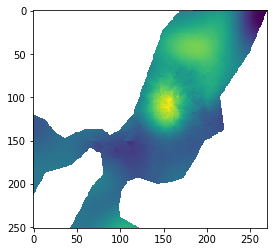

In [30]:
plt.close()
plt.imshow(arr)
plt.show()

In [31]:
# OPen an AEM grid, resample them onto the same affine as the stratigraphy
# and save them as a multiband array

import glob

os.chdir(r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\EK_nbc_inversions\OrdKeep_borehole_constrained\gdal_grids\grids\layergrids")

cond = np.nan*np.ones(shape = (30, arr.shape[0], arr.shape[1]),
                      dtype = np.float32)
intervals = np.zeros(shape = (30,2), dtype = np.float32)

for i, file in enumerate(glob.glob('*.tif')):
    
    print(file)
    
    cond[i] = resample_raster2array(file, aff, arr.shape,
                                    driver='GTiff', null = 0)
    
    intervals[i] = [float(file.split('_')[2]), float(file.split('_')[3])]
    


layer_29_430.9_500.0_m.tif
layer_30_500.0_Inf_m.tif
layer_28_371.3_430.9_m.tif
layer_27_319.9_371.3_m.tif
layer_26_275.7_319.9_m.tif
layer_25_237.6_275.7_m.tif
layer_24_204.7_237.6_m.tif
layer_23_176.3_204.7_m.tif
layer_22_151.9_176.3_m.tif
layer_21_130.8_151.9_m.tif
layer_20_112.6_130.8_m.tif
layer_19_096.9_112.6_m.tif
layer_18_083.4_096.9_m.tif
layer_17_071.7_083.4_m.tif
layer_16_061.6_071.7_m.tif
layer_15_052.9_061.6_m.tif
layer_14_045.3_052.9_m.tif
layer_13_038.8_045.3_m.tif
layer_12_033.1_038.8_m.tif
layer_11_028.1_033.1_m.tif
layer_10_023.8_028.1_m.tif
layer_09_020.0_023.8_m.tif
layer_08_016.6_020.0_m.tif
layer_07_013.6_016.6_m.tif
layer_06_010.9_013.6_m.tif
layer_05_008.4_010.9_m.tif
layer_04_006.2_008.4_m.tif
layer_03_004.0_006.2_m.tif
layer_02_002.0_004.0_m.tif
layer_01_000.0_002.0_m.tif


In [32]:
# Sort so the first layer is the first matrix in the array

inds = intervals.argsort(axis = 0)[:,0]

intervals = intervals[inds]

cond = cond[inds]


In [33]:
cond_intervals = intervals.copy()

In [34]:
cond_intervals

array([[  0. ,   2. ],
       [  2. ,   4. ],
       [  4. ,   6.2],
       [  6.2,   8.4],
       [  8.4,  10.9],
       [ 10.9,  13.6],
       [ 13.6,  16.6],
       [ 16.6,  20. ],
       [ 20. ,  23.8],
       [ 23.8,  28.1],
       [ 28.1,  33.1],
       [ 33.1,  38.8],
       [ 38.8,  45.3],
       [ 45.3,  52.9],
       [ 52.9,  61.6],
       [ 61.6,  71.7],
       [ 71.7,  83.4],
       [ 83.4,  96.9],
       [ 96.9, 112.6],
       [112.6, 130.8],
       [130.8, 151.9],
       [151.9, 176.3],
       [176.3, 204.7],
       [204.7, 237.6],
       [237.6, 275.7],
       [275.7, 319.9],
       [319.9, 371.3],
       [371.3, 430.9],
       [430.9, 500. ],
       [500. ,   inf]], dtype=float32)

In [35]:
# Create the log conductivity array

logcond =np.log10(cond)


C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


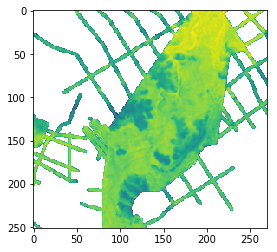

In [36]:
plt.close()
plt.imshow(logcond[0])

plt.show()

In [37]:
# Open water table raster

wt_file = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\KeepWaterTable\raster_elevation_interpolation\nulled\KeepRiver_water_table_mBGL.tif"
wt_depth = resample_raster2array(wt_file, aff, logMob.shape)



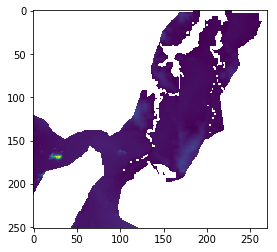

In [39]:
plt.close()
plt.imshow(wt_depth)

plt.show()

In [38]:
depth_top = intervals[:,0]

In [40]:
logMob.shape

(251, 270)

In [41]:
# Now we want to iterate through the mobile water coordinates
# and calculate the AEM for a depth interval at that point

log_AEM_interval = np.nan*np.ones(shape = (logMob.shape),
                                  dtype = np.float32)

for i in range(logMob.shape[0]):
    for j in range(logMob.shape[1]):
        top = wt_depth[i,j]
        base = top + 5.

        if (~np.isnan(top)) and (top < base):
            top_ind = np.searchsorted(depth_top, top)
            base_ind = np.searchsorted(depth_top, base)
            
            # Now use these indices to slice and average the log10 AEM
            if top_ind == base_ind:
                log_AEM_interval[i,j] = logcond[top_ind,i,j]
            elif top_ind < base_ind:
                log_AEM_interval[i,j] = slice_conductivity(logcond[:,i,j], cond_intervals, base, top)
            else:
                print('error')


        


C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\scipy\interpolate\interpolate.py:613: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\scipy\interpolate\interpolate.py:610: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [44]:
# Now calculate water quality using Archie's law and an assumed value of m

m = 0.071490 # From Cenozoic borehole analysis

logcw = log_AEM_interval - (m * logMob)

In [46]:
outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\OrdKeep_water_quality\results"

outfile = os.path.join(outdir, 'Keep_top5m_saturated_EC.tif')

EC = 10**logcw

new_dataset = rasterio.open(outfile, 'w', driver='GTiff',
                                height= EC.shape[0], width=EC.shape[1],
                                count=1, dtype=np.float32,
                                crs=mob_water_src.crs, transform=aff)
new_dataset.write(EC, 1)

new_dataset.close()

In [47]:
TDS = (EC/1.57) * 10000. # From Steve - source Freeze and Cherry 1979

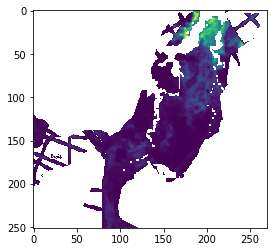

In [49]:
plt.imshow(TDS)
plt.show()

In [51]:
# Export as a raster

outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\OrdKeep_water_quality"

outfile = os.path.join(outdir, "Keep_top5m_saturated_TDS.tif")

new_dataset = rasterio.open(outfile, 'w', driver='GTiff',
                                height= TDS.shape[0], width=TDS.shape[1],
                                count=1, dtype=np.float32,
                                crs=mob_water_src.crs, transform=aff)
new_dataset.write(TDS, 1)

new_dataset.close()

In [52]:
outfile

'\\\\prod.lan\\active\\proj\\futurex\\East_Kimberley\\Working\\SharedWorkspace\\OrdKeep_water_quality\\Keep_top5m_saturated_TDS.tif'